In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.spaceinvaders.linear"
snapshot_path = "/home/jheuristic/yozhik/agentnet_snapshots/"

GAME_TITLE = 'SpaceInvaders-v0'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'
Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
%load_ext autoreload
%autoreload 2

# This tutorial is a showcase on how to use AgentNet to learn arbitrary problems

fillmeout

# Experiment setup
* Here we write a simple wrapper for 2048 web-game using selenium browser

INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:49,762] Making new env: SpaceInvaders-v0


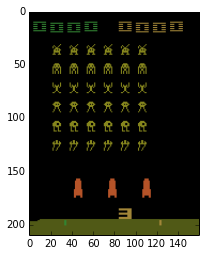

In [4]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

In [5]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# agent setup
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * in this case, the resolver has epsilon-greedy policy
  
  
### Simple no-memory model

Since we have almost fully observable environment AND we want to keep baseline simple, we shall use NO agent memories and a simple lasagne CNN to process observations.



In [6]:
observation_shape

(None, 210, 160, 3)

In [7]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [8]:
import lasagne

#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images imput")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))

#convolution

cnn = lasagne.layers.Conv2DLayer(observation_reshape,num_filters=32,filter_size=(5,5),name='cnn0')
cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool0')
cnn = lasagne.layers.Conv2DLayer(cnn,num_filters=64,filter_size=(5,5),name='cnn1')
cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool1')




#memory

#no memory this time



#q_eval
q_eval = lasagne.layers.DenseLayer(cnn,
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,
                                   name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.5),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



from collections import OrderedDict
#all together
agent = Agent(observation_layer,
              {},
              q_eval,resolver)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[cnn0.W, cnn0.b, cnn1.W, cnn1.b, QEvaluator.W, QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * to be covered where they are more useful
 

* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


# creating sessions

In [10]:
applier_observation = T.tensor4("input image",dtype=floatX)


res =agent.get_agent_reaction({},applier_observation)


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation],
        applier_actions)

In [11]:
#A whole lot of space invaders
ataries = [gym.make(GAME_TITLE) for i in range(10)]
for atari in ataries:
    atari.reset()

INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,009] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,038] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,068] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,097] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,125] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,152] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,180] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: SpaceInvaders-v0
[2016-04-29 02:11:51,208] Making new env: SpaceInvaders-v0
INFO:gym.envs.registration:Making new env: Space

In [12]:
def interact(ataries,n_steps = 100):

    history_log = []
        
    prev_observations = map(lambda atari: atari.render('rgb_array'), ataries)
    
    
    
    for i in range(n_steps):
        
        actions = applier_fun(prev_observations)[0]
        
        new_observations, cur_rewards, is_done, infos = zip(*map(lambda atari, action: atari.step(action), 
                                                            ataries,actions))
        
        for i in range(len(ataries)):
            if is_done[i]:
                ataries[i].reset()
                print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,is_done))
        prev_observations = new_observations
                
    
    
    return zip(*history_log)
        
    
    
    
    
    

In [13]:
%%time
obsevation_log,action_log,reward_log,is_done_log  = interact(ataries,50)


print np.array(reward_log[:10]).T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['FIRE' 'RIGHTFIRE' 'LEFT' 'FIRE' 'RIGHTFIRE']
 ['LEFT' 'FIRE' 'NOOP' 'FIRE' 'RIGHT']
 ['LEFTFIRE' 'LEFT' 'FIRE' 'FIRE' 'FIRE']]
CPU times: user 16.3 s, sys: 29.7 s, total: 46 s
Wall time: 5.77 s


# experience replay pool
### we shall use session pool environment to immediately train on new sessions
* theoretically, this environemnt is designed for storing a lot of game sessions and training on random batches,
* but for the sake of baseline, it's a one-time usage pool

1. Interact with ALE, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat

In [41]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [42]:
def update_pool(env, ataries,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    obsevation_log,action_log,reward_log,is_done_log= interact(ataries,n_steps=n_steps)
    
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(obsevation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [43]:
replay_seq_len = 25
update_pool(env,ataries,replay_seq_len)

# Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [44]:
#produce interaction sequences of length <= 10

_,observation_seq,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)


#observation seq are the observation tensor we just loaded
#qvalues seq are agent's Qvalues obtained via experience replay


#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now

#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [59]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        action_seq,
                                                        rewards_seq,
                                                        is_alive_seq,
                                                        gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / is_alive_seq.sum()

In [60]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [61]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [62]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [63]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [64]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools

### [warning, this thing basicly tries to track various Qvalues over time]
### [but it's bulky and stupid, so don't try to understand it if it didn't come naturally]


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [73]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3):
        
        
    printables = map(lambda v: v[:max_n_sessions],  get_printables())
    
    
    qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = printables
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   reference_policy_seq = reference_qv_log,
                   action_names=action_names,
                   legend = True, #do not show legend since there's too many labeled objects
                  plot_policy = with_plots)

session # 0
 FIRE(qv = 0.0) -> 0.0(ref = 5536.50097656) |  NOOP(qv = -11.4992656708) -> 0.0(ref = 7444.83984375) |  FIRE(qv = 78.7202301025) -> 0.0(ref = 6.62601280212) |  FIRE(qv = 80.1538162231) -> 0.0(ref = 13.2044782639) |  FIRE(qv = 80.5473937988) -> 0.0(ref = 9.5097360611) |  FIRE(qv = 81.5406417847) -> 0.0(ref = 22.6712779999) |  FIRE(qv = 80.8202133179) -> 0.0(ref = 1.706153512) |  FIRE(qv = 83.69896698) -> 0.0(ref = 18.0361156464) |  RIGHT(qv = -31.2154788971) -> 0.0(ref = 12078.65625) |  LEFT(qv = -19.5715141296) -> 0.0(ref = 10222.2939453) |  RIGHT(qv = -31.4529457092) -> 0.0(ref = 10510.7958984) |  FIRE(qv = 74.809715271) -> 0.0(ref = 27.4509410858) |  FIRE(qv = 73.2319488525) -> 0.0(ref = 24.80560112) |  NOOP(qv = -22.8112411499) -> 0.0(ref = 8491.65136719) |  FIRE(qv = 72.9883270264) -> 0.0(ref = 22.6799240112) |  FIRE(qv = 71.8168258667) -> 0.0(ref = 49.0075836182) |  RIGHT(qv = -28.5307655334) -> 0.0(ref = 9051.64550781) |  LEFT(qv = -27.6190738678) -> 0.0(ref = 9167.44

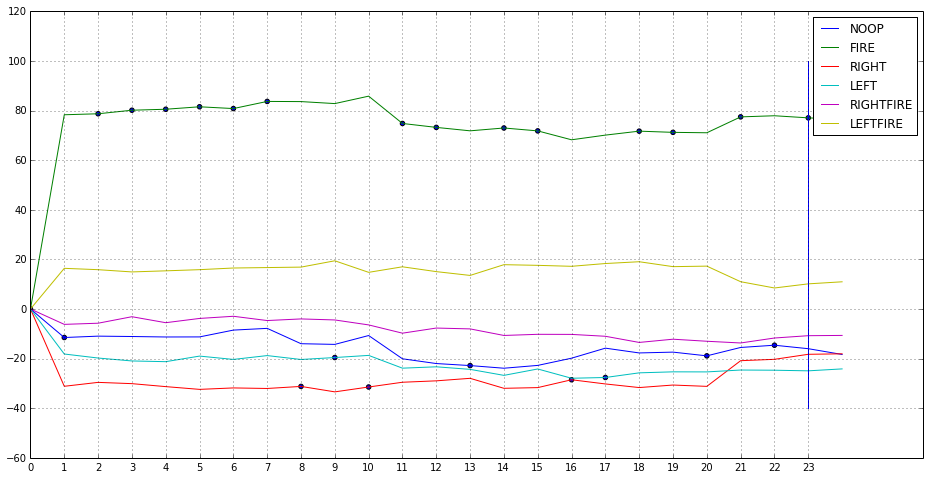

session # 1
 FIRE(qv = 0.0) -> 0.0(ref = 6034.63769531) |  LEFT(qv = -30.6979637146) -> 0.0(ref = 11917.5751953) |  FIRE(qv = 82.5996627808) -> 0.0(ref = 6.6447224617) |  FIRE(qv = 84.2336044312) -> 0.0(ref = 20.8315849304) |  FIRE(qv = 83.8625717163) -> 0.0(ref = 36.1151733398) |  FIRE(qv = 81.9505081177) -> 0.0(ref = 25.4363040924) |  RIGHTFIRE(qv = -4.15318202972) -> 20.0(ref = 10366.4472656) |  NOOP(qv = -8.91526603699) -> 0.0(ref = 7713.28222656) |  NOOP(qv = -11.5042896271) -> 0.0(ref = 8189.41992188) |  NOOP(qv = -10.6517744064) -> 0.0(ref = 7372.99169922) |  FIRE(qv = 79.1730041504) -> 0.0(ref = 10.6548910141) |  FIRE(qv = 79.9040222168) -> 0.0(ref = 3.69653654099) |  FIRE(qv = 82.0856704712) -> 0.0(ref = 14.013961792) |  NOOP(qv = -12.2950086594) -> 0.0(ref = 7795.31982422) |  FIRE(qv = 79.9958953857) -> 0.0(ref = 9.28377246857) |  LEFT(qv = -23.5647773743) -> 0.0(ref = 9948.18164062) |  RIGHT(qv = -35.1753120422) -> 0.0(ref = 12604.6054688) |  FIRE(qv = 81.1525421143) -> 0.0(

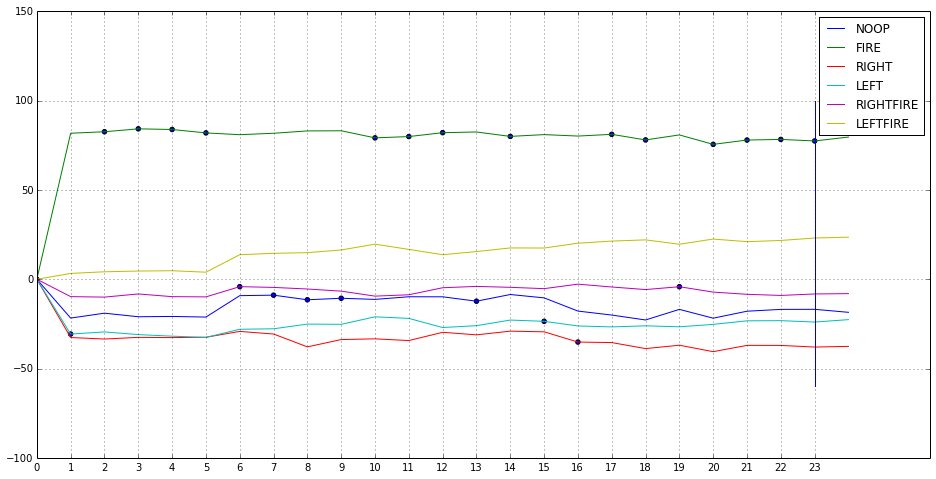

session # 2
 LEFT(qv = 0.0) -> 0.0(ref = 5406.63378906) |  LEFTFIRE(qv = 5.78288269043) -> 0.0(ref = 4589.64697266) |  LEFT(qv = -26.188495636) -> 0.0(ref = 10066.5683594) |  LEFT(qv = -25.9210090637) -> 0.0(ref = 9890.46582031) |  FIRE(qv = 77.399810791) -> 0.0(ref = 10.6016635895) |  FIRE(qv = 78.0460968018) -> 0.0(ref = 15.2279891968) |  LEFT(qv = -25.9210090637) -> 0.0(ref = 9890.46582031) |  RIGHT(qv = -30.5812644958) -> 0.0(ref = 10967.3369141) |  FIRE(qv = 78.0460968018) -> 0.0(ref = 20.3967952728) |  FIRE(qv = 77.399810791) -> 0.0(ref = 10.6016635895) |  FIRE(qv = 78.0460968018) -> 0.0(ref = 15.2279891968) |  FIRE(qv = 78.0460968018) -> 0.0(ref = 20.3967952728) |  LEFTFIRE(qv = 5.78288269043) -> 0.0(ref = 4673.21386719) |  LEFT(qv = -25.9210090637) -> 0.0(ref = 9890.46582031) |  FIRE(qv = 77.399810791) -> 0.0(ref = 14.9768619537) |  LEFT(qv = -26.188495636) -> 0.0(ref = 10066.5683594) |  FIRE(qv = 78.0460968018) -> 0.0(ref = 20.3967952728) |  FIRE(qv = 77.399810791) -> 0.0(ref 

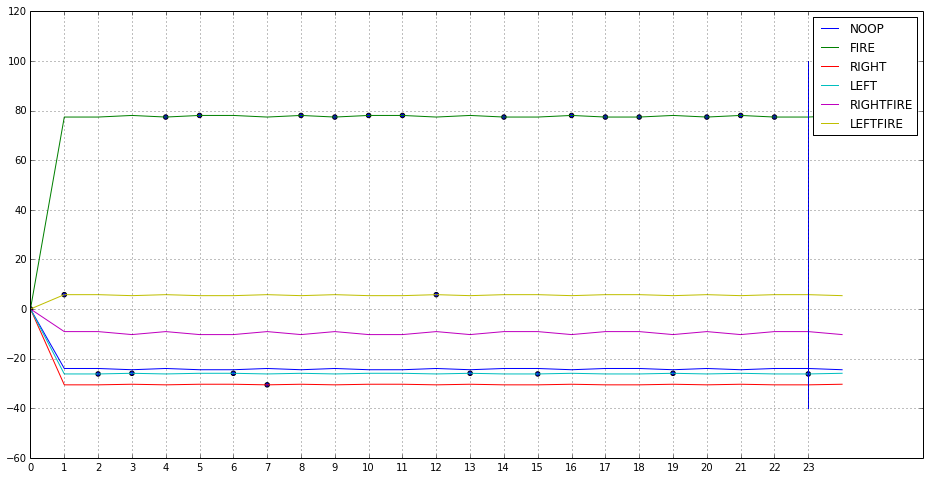

In [74]:
#visualize untrained network performance (which is mostly random)
epsilon.set_value(0.05)
display_sessions(with_plots=True)

# Training loop

In [75]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [76]:
from agentnet.display import Metrics
score_log = Metrics()

In [77]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [78]:
n_epochs = 100000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,ataries,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %100 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

epoch 1,loss 682.94593, epsilon 0.49910, rewards: ( e-greedy 1.30000, greedy 1.30000) 
rec 682.940 reg 0.006


KeyboardInterrupt: 

In [ ]:
current_epsilon

# Evaluating results

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
rebuild_pool(gw)
display_sessions(with_plots=True)


In [ ]:
#load earlier snapshot.
#warning - this overrides the latest network params with earlier ones. 
#Replace 20000 with some 100000 if you wish to load latest snapshod back.
snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), 20000)
load(resolver,snap_name)

In [ ]:
print "Random session examples"
rebuild_pool(gw)
display_sessions(with_plots=True)
